### cGAN_Keras with MNIST data set as sample.
Code get from  https://github.com/mabagheri/CGAN/blob/master/cgan_Keras.py

#### 1. Import Library

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
import numpy as np

#### 2. Define Class

In [9]:
class CGAN:
    def __init__(self, img_width, img_height, n_channels, n_classes):
        self.img_width = img_width
        self.img_height = img_height
        self.n_channels = n_channels
        self.img_shape = (self.img_width, self.img_height, self.n_channels)
        self.n_classes = n_classes
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator_model()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim, ))
        label = Input(shape=(self.n_classes,))
        img = self.generator([noise, label])

        # during generator updating,  the discriminator is fixed (will not be updated).
        self.discriminator.trainable = False

        # The discriminator takes generated image and label as input and determines its validity
        validity = self.discriminator([img, label])

        self.cgan_model = Model(inputs=[noise, label], outputs=validity) # https://github.com/keras-team/keras/issues/13743
        self.cgan_model.compile(loss=['binary_crossentropy'],
                                optimizer=optimizer,
                                metrics=['accuracy'])

        plot_model(self.cgan_model, show_shapes=True, to_file='cgan-adversarial_model.png')
        plot_model(self.generator, show_shapes=True, to_file='cgan-generator_model.png')
        plot_model(self.discriminator, show_shapes=True, to_file='cgan-discriminator.png')

    def build_discriminator_model(self):

        model_input = Input(shape=(self.img_width, self.img_height, self.n_channels), name='discriminator_input')

        x = model_input

        labels = Input(shape=(self.n_classes,))
        # labels_embedded = Flatten()(Embedding(self.num_classes, self.latent_dim)(labels))
        labels_embedded = Dense(self.img_width * self.img_width)(labels)
        labels_embedded = Reshape((self.img_width, self.img_height, self.n_channels))(labels_embedded)

        x = concatenate([x, labels_embedded])
        x = LeakyReLU(alpha=0.1)(x)

        x = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)

        x = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)

        x = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)

        x = Conv2D(filters=256, kernel_size=5, strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)

        x = Flatten()(x)
        x = Dense(1)(x)
        x = Activation('sigmoid')(x)
        # model_input is conditioned by labels
        discriminator = Model([model_input, labels], x, name='discriminator')

        return discriminator

    def build_generator(self):
        image_resize = self.img_height // 4

        inputs = Input(shape=(self.latent_dim,), name='z_input')
        labels = Input(shape=(self.n_classes,), name='class_labels')

        x = concatenate([inputs, labels], axis=1)
        x = Dense(image_resize * image_resize * 128)(x)
        x = Reshape((image_resize, image_resize, 128))(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same')(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same')(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same')(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=1, kernel_size=5, strides=1, padding='same')(x)

        x = Activation('sigmoid')(x)
        # input is conditioned by labels
        generator = Model(inputs=[inputs, labels], outputs=x, name='generator') # https://github.com/keras-team/keras/issues/13743
        return generator

    def train(self, x_train, y_train, epochs=1000, batch_size=128, sample_interval=50):

        x_train = np.reshape(x_train, [-1, self.img_width, self.img_height, self.n_channels])
        x_train = x_train.astype('float32') / 255

        y_train = to_categorical(y_train)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  --------------------- Train Discriminator ---------------------
            # Select a random half batch of images
            idx = np.random.randint(0, x_train.shape[0], size=batch_size)
            imgs, labels = x_train[idx], y_train[idx]

            # Generate sample noise for generator input
            noise = self.generate_noise("uniform_noise", batch_size)

            # Generate a half batch of new images
            # we can use labels instead of fake_labels; because it is fake for noise
            gen_imgs = self.generator.predict([noise, labels])

            # --------------------- Train the Discriminator ---------------------
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], real)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  --------------------- Train the Generator ---------------------
            # Condition on labels (random one-hot labels)
            fake_labels = np.eye(self.n_classes)[np.random.choice(self.n_classes, batch_size)]

            # Train the generator
            cgan_loss, acc = self.cgan_model.train_on_batch([noise, fake_labels], real)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], cgan_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch) # TO-DOm not working in google colab

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.uniform(-1.0, 1.0, size=[r * c, self.latent_dim])

        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        sampled_labels_categorical = to_categorical(sampled_labels)

        gen_imgs = self.generator.predict([noise, sampled_labels_categorical])

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch, bbox_inches='tight', dpi=200)
        plt.close()

    def generate_noise(self, type_of_noise, batch_size):
        if type_of_noise == "normal_noise":
            return np.random.normal(0, 1, size=[batch_size, self.latent_dim])

        elif type_of_noise == "uniform_noise":
            return np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_dim])

#### 3. main method

0 [D loss: 0.712798, acc.: 4.69%] [G loss: 0.689517]


FileNotFoundError: ignored

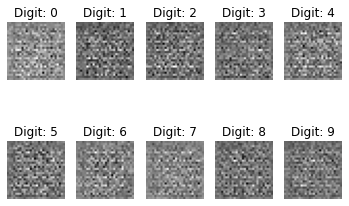

In [10]:
(X, y), (_, _) = mnist.load_data()
num_classes = 10

if X[0].ndim == 3:
    img_w, img_h, num_channels = X[0].shape
else:
    img_w, img_h = X[0].shape
    num_channels = 1

cgan = CGAN(img_w, img_h, num_channels, num_classes)

cgan.train(X, y, epochs=20000, batch_size=32, sample_interval=300)